# Hamiltonian Monte Carlo with leapfrog

Scalar version: https://github.com/genkuroki/public/blob/main/0018/HMC%20leapfrog.ipynb

In [1]:
module My

using ConcreteStructs: @concrete
using Parameters: @unpack

using LinearAlgebra: dot
using ForwardDiff: gradient
using Random: default_rng, randn!
using StaticArrays: SVector, MVector

@concrete struct LFProblem{dim} ϕ; H; F; dt; nsteps end

"""ϕ should be a potential function."""
function LFProblem(dim, ϕ; dt = 1.0, nsteps = 40)
    H(x, v, param) = dot(v, v)/2 + ϕ(x, param)
    F(x, param) = -gradient(x -> ϕ(x, param), x)
    LFProblem{dim}(ϕ, H, F, dt, nsteps)
end

"""Numerically solve Hamilton's equation of motion with leapfrog method"""
function solve(lf::LFProblem, x, v, param)
    @unpack F, dt, nsteps = lf
    v = v + F(x, param)*dt/2
    x = x + v*dt
    for _ in 2:nsteps
        v = v + F(x, param)*dt
        x = x + v*dt
    end
    v = v + F(x, param)*dt/2
    x, v
end

@inline function _update!(lf::LFProblem{dim}, x, vtmp, param, rng) where dim
    @unpack H = lf
    v = SVector{dim}(randn!(rng, vtmp))
    xnew, vnew = solve(lf, x, v, param)
    dH = H(xnew, vnew, param) - H(x, v, param)
    rand(rng) ≤ exp(-dH) ? xnew : x
end

"""Hamiltonian Monte Carlo"""
function HMC(lf::LFProblem{dim}, param = nothing;
        niters = 10^5, thin = 1, nwarmups = 0, rng = default_rng(),
        init = SVector{dim}(randn(rng, dim))) where dim
    vtmp = MVector{dim}(zeros(eltype(init), dim))
    x = init
    for _ in 1:nwarmups
        x = _update!(lf, x, vtmp, param, rng)
    end
    sample = Vector{typeof(init)}(undef, niters)
    for i in 1:niters
        for _ in 1:thin
            x = _update!(lf, x, vtmp, param, rng)
        end
        @inbounds sample[i] = x
    end
    sample
end

end

Main.My

In [2]:
using Plots
using BenchmarkTools
using StaticArrays
using LinearAlgebra
using KernelDensity
using Statistics
using QuadGK
using Distributions

## 2-dimensional normal distribution

In [3]:
A = @SMatrix [
     1  1/2
    1/2  1
]
param = (; A = A)
ϕ(x, param) = dot(x, param.A, x)/2
lf = My.LFProblem(2, ϕ)

Main.My.LFProblem{2, typeof(ϕ), Main.My.var"#H#3"{typeof(ϕ)}, Main.My.var"#F#4"{typeof(ϕ)}, Float64, Int64}(ϕ, Main.My.var"#H#3"{typeof(ϕ)}(ϕ), Main.My.var"#F#4"{typeof(ϕ)}(ϕ), 1.0, 40)

In [4]:
@time sample = My.HMC(lf, param)
@time sample = My.HMC(lf, param)
@time sample = My.HMC(lf, param);

  0.733419 seconds (2.05 M allocations: 128.161 MiB, 2.97% gc time, 92.68% compilation time)
  0.053143 seconds (4 allocations: 1.526 MiB)
  0.053475 seconds (4 allocations: 1.526 MiB)


In [5]:
@btime My.HMC($lf, $param);

  53.672 ms (4 allocations: 1.53 MiB)


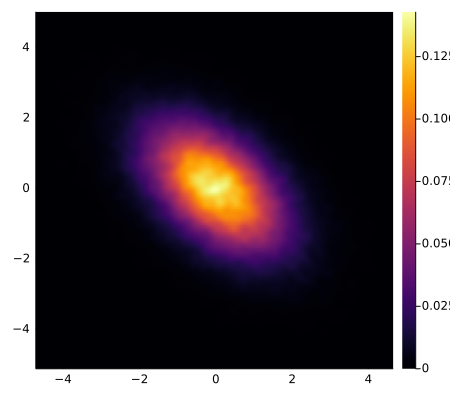

In [6]:
X, Y = first.(sample), last.(sample)
d = InterpKDE(kde((X, Y)))
x, y = range(extrema(X)...; length=201), range(extrema(Y)...; length=201)
heatmap(x, y, (x, y) -> pdf(d, x, y); size=(450, 400))

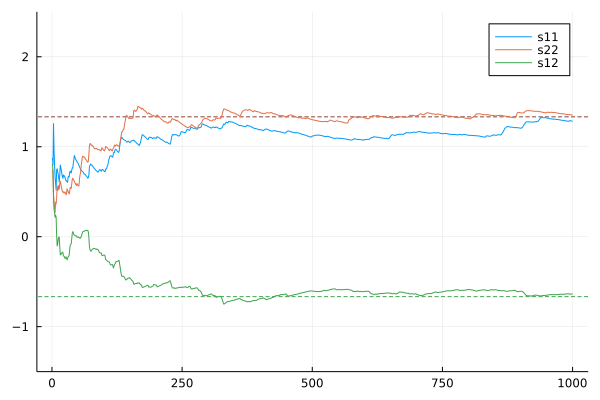

In [7]:
f(n) = mean(x -> x*x', @view sample[1:n])

n = 1:1000
S = f.(n)
S11 = (S -> S[1,1]).(S)
S22 = (S -> S[2,2]).(S)
S12 = (S -> S[1,2]).(S)

ymin = min(-1.5, minimum(S11), minimum(S22), minimum(S12))
ymax = max(2.5, maximum(S11), maximum(S22), maximum(S12))

plot(ylim = (ymin, ymax))
plot!(S11; label="s11", c=1)
hline!([inv(A)[1,1]]; label="", c=1, ls=:dash)
plot!(S22; label="s22", c=2)
hline!([inv(A)[2,2]]; label="", c=2, ls=:dash)
plot!(S12; label="s12", c=3)
hline!([inv(A)[1,2]]; label="", c=3, ls=:dash)

## φ(x) = a(x - 1)²

  0.232911 seconds (567.10 k allocations: 36.201 MiB, 62.24% compilation time)
  0.085816 seconds (14 allocations: 1.526 MiB)
  0.087256 seconds (14 allocations: 1.526 MiB)
  0.088414 seconds (14 allocations: 1.526 MiB)
  0.085660 seconds (14 allocations: 1.526 MiB)
  0.088306 seconds (14 allocations: 1.526 MiB)


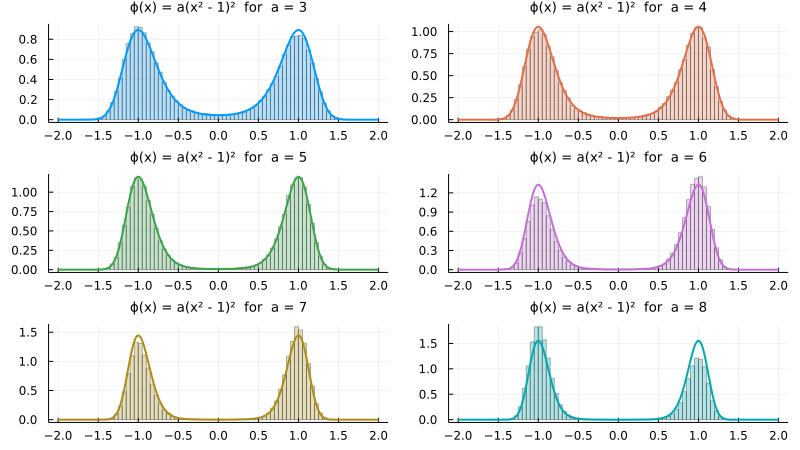

In [8]:
ϕ4(x, a) = a * (x[1]^2 - 1)^2
a = [3, 4, 5, 6, 7, 8]
XX = Vector{Float64}[]
ZZ = Float64[]
PP = []
for i in eachindex(a)
    Z = quadgk(x -> exp(-ϕ4((x,), a[i])), -Inf, Inf)[1]
    push!(ZZ, Z)
    lf = My.LFProblem(1, ϕ4; dt = 0.05, nsteps = 100)
    @time X = first.(My.HMC(lf, a[i]))
    flush(stdout)
    push!(XX, X)
    P = plot()
    histogram!(X; norm=true, alpha=0.3, label="HMC LF sample", bin=100, c=i)
    plot!(x -> exp(-ϕ4(x, a[i]))/Z, -2, 2; label="exp(-ϕ2(x))/Z", lw=2, c=i)
    plot!(; legend=false, xtick=-2:0.5:2)
    title!("ϕ(x) = a(x² - 1)²  for  a = $(a[i])", titlefontsize=9)
    push!(PP, P)
end
plot(PP...; size=(800, 450), layout=(3, 2))

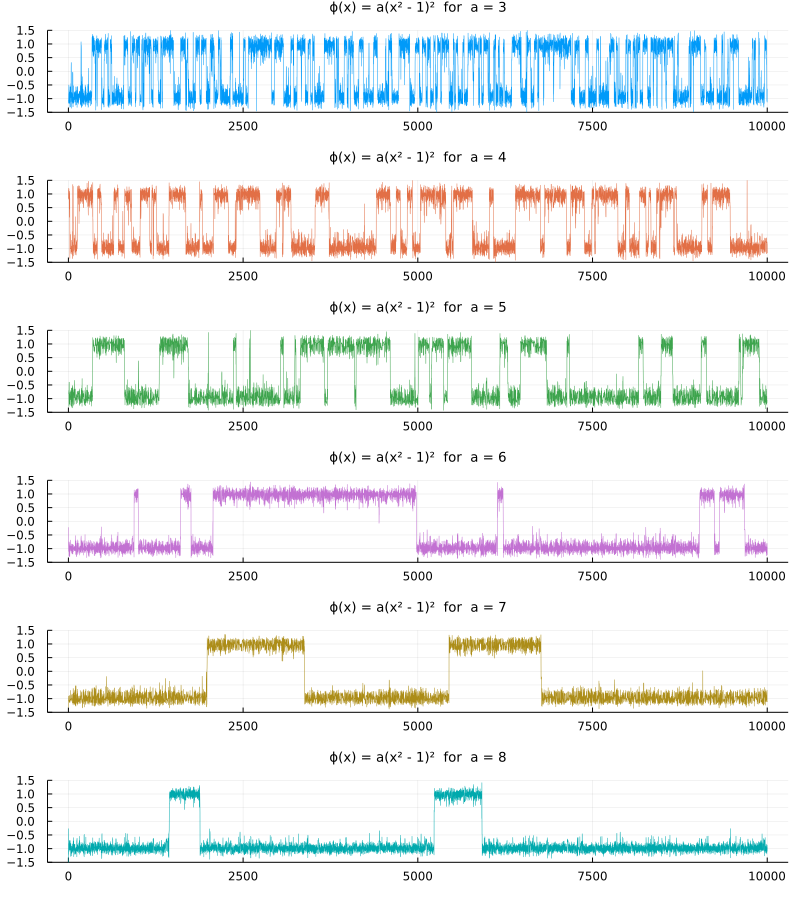

In [9]:
QQ = []
for i in eachindex(a)
    Q = plot(XX[i][1:10000]; ylim=(-1.5, 1.5), label="", c=i, lw=0.5)
    title!("ϕ(x) = a(x² - 1)²  for  a = $(a[i])", titlefontsize=9)
    push!(QQ, Q)
end
plot(QQ...; size=(800, 900), layout=(length(a), 1))

## Baysian inference for a sample of the standard normal distribution

In [10]:
n = 10
sample_normal = randn(n)
f(y, m, s) = (y - m)^2/(2s^2) + log(s)
negloglik(w, sample) = sum(y -> f(y, w[1], exp(w[2])), sample)
lf = My.LFProblem(2, negloglik; dt = 0.1, nsteps = 30)

Main.My.LFProblem{2, typeof(negloglik), Main.My.var"#H#3"{typeof(negloglik)}, Main.My.var"#F#4"{typeof(negloglik)}, Float64, Int64}(negloglik, Main.My.var"#H#3"{typeof(negloglik)}(negloglik), Main.My.var"#F#4"{typeof(negloglik)}(negloglik), 0.1, 30)

In [11]:
@time sample = My.HMC(lf, sample_normal; init = SVector(0.0, 0.0))
@time sample = My.HMC(lf, sample_normal; init = SVector(0.0, 0.0))
@time sample = My.HMC(lf, sample_normal; init = SVector(0.0, 0.0))

  0.882696 seconds (511.27 k allocations: 31.631 MiB, 1.58% gc time, 21.95% compilation time)
  0.691170 seconds (3 allocations: 1.526 MiB)
  0.747255 seconds (3 allocations: 1.526 MiB)


100000-element Vector{SVector{2, Float64}}:
 [1.0315441836293853, -0.060580383776054375]
 [0.4276365132824157, 0.3119765321580789]
 [0.5446721706169404, 0.28791390604490175]
 [0.2301928263888833, 0.2055403521666663]
 [0.49070275168795346, 0.2491176040279598]
 [0.401517998203003, 0.0870712265293336]
 [0.6970371693558954, 0.05392154079078285]
 [0.2805477653809646, -0.013085545622944256]
 [0.6544331608555919, 0.08341644314675212]
 [0.6697214241714387, 0.1666266560930162]
 [0.2843769834815044, 0.30770401373881273]
 [1.0048932503411008, 0.30087191766957433]
 [-0.333581427270499, 0.1391342721454599]
 ⋮
 [0.2557704561392279, 0.08217431932634664]
 [0.5755788172501917, 0.042636541664946896]
 [0.6241113012630647, 0.05303120471668896]
 [0.8524218596052101, -0.19205201524939508]
 [0.1412363349573767, -0.1091576432761234]
 [0.7328225823882413, 0.006775050920265646]
 [0.21573747264181511, -0.1481726366335358]
 [0.8631877442320044, -0.28170155465086083]
 [0.5200790811433048, 0.14276139918082165]
 [0.

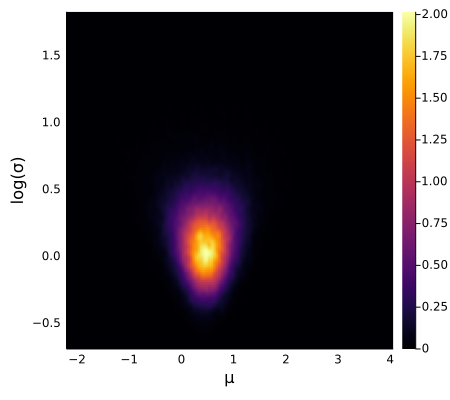

In [12]:
m, logs = first.(sample), last.(sample)
d = InterpKDE(kde((m, logs)))
x, y = range(extrema(m)...; length=201), range(extrema(logs)...; length=201)
heatmap(x, y, (x, y) -> pdf(d, x, y); size=(450, 400), xlabel="μ", ylabel="log(σ)")